# rCSI time-series dataset released by WFP

In this notebook, I create the time-series regarding the **Reduced Coping Strategy Index (rCSI)** indicator.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import pandas as pd
import numpy as np
import ntpath
import glob
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from map_plot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Read the data released by wfp regarding the rCSI indicator.
path = "./wfp_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_files = glob.glob(path + country + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename)
        df["Country"] = country
        dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2019-7-15_2019-9-8,2019-09-08,BOUCLE-DU-MOUHOUN,900712,19.49950,1816310,354171,Burkina Faso
1,2019-7-15_2019-9-8,2019-09-08,CASCADES,900713,8.43056,755896,63726,Burkina Faso
2,2019-7-15_2019-9-8,2019-09-08,CENTRE,900714,7.58997,2623394,199114,Burkina Faso
3,2019-7-15_2019-9-8,2019-09-08,CENTRE-EST,900715,20.05105,2623394,526018,Burkina Faso
4,2019-7-15_2019-9-8,2019-09-08,CENTRE-NORD,900716,18.75761,1551284,290983,Burkina Faso


### Brief items description

- *SvyDate*: reference period of the data collection;
- *Date*: reference date (i.e. the end of the reference period);
- *Dmgrph*: administrative area name;
- *DmgrphCode*: a code for identyfing the adminstrata;
- *Mean_crrnt*: corresponds to the % of people with rCSI>=19 during the corresponding SvyDate; 
- *Pop*: area population size;
- *PopNmbr*: number of people with rCSI>=19.

In [6]:
# Check if the dataframe contains NaN values.
print("Check if the dataframe contains some NaN values:")
df.isnull().sum()

Check if the dataframe contains some NaN values:


SvyDate       0
Date          0
Dmgrph        0
DmgrphCode    0
Mean_crrnt    0
Pop           0
PopNmbr       0
Country       0
dtype: int64

In [7]:
# Let's delete some items because they are not of interest in this notebook.
df.drop(["DmgrphCode", "Pop", "PopNmbr"], axis = 1, inplace = True) 

In [8]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "Metric"}, inplace = True)

In [9]:
# Check the temporal ranges of the SvyDate column based on country creating two new columns.
df[["SvyDate1", "SvyDate2"]] = df["SvyDate"].apply(lambda x: pd.Series([pd.to_datetime(x.split("_")[0]), pd.to_datetime(x.split("_")[1])]))
# The new column 'SvyDateRange' indicates the coverage of days of the survey.
df["SvyDateRange"] = (df["SvyDate2"] - df["SvyDate1"]).dt.days + 1
df.head()

,SvyDate,Datetime,AdminStrata,Metric,Country,SvyDate1,SvyDate2,SvyDateRange
0,2019-7-15_2019-9-8,2019-09-08,BOUCLE-DU-MOUHOUN,19.49950,Burkina Faso,2019-07-15,2019-09-08,56
1,2019-7-15_2019-9-8,2019-09-08,CASCADES,8.43056,Burkina Faso,2019-07-15,2019-09-08,56
2,2019-7-15_2019-9-8,2019-09-08,CENTRE,7.58997,Burkina Faso,2019-07-15,2019-09-08,56
3,2019-7-15_2019-9-8,2019-09-08,CENTRE-EST,20.05105,Burkina Faso,2019-07-15,2019-09-08,56
4,2019-7-15_2019-9-8,2019-09-08,CENTRE-NORD,18.75761,Burkina Faso,2019-07-15,2019-09-08,56


In [10]:
# Print the coverages of the survey for each country and their frequency.
for country in df.Country.unique():
    day_range = df[df.Country == country]["SvyDateRange"].value_counts()
    print(country)
    print(day_range)

Burkina Faso
56    4745
Name: SvyDateRange, dtype: int64
Nigeria
31    1587
30     189
Name: SvyDateRange, dtype: int64
Syria
31    9149
Name: SvyDateRange, dtype: int64
Yemen
31    16188
Name: SvyDateRange, dtype: int64


This information will be useful when adapting the time-series of other indicators (see other notebooks) to this coverage format.

**N.B.** Nigeria country have two different coverage values. We have decided to take the more frequent of the two as a reference value.

### Country item

In [11]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Nigeria, Syria, Yemen


### AdminStrata item

In [12]:
# The strings of the adminstratas of Burkina Faso country are uppercase, we change them to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country == "Burkina Faso":
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [13]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the governorates of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago.  The rCSI dataframe has the values of all the 22 governorates.

In [14]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Aden', 'Al Bayda', "Al Dhale'e", 'Al Hudaydah',
       'Al Jawf', 'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran',
       'Dhamar', 'Hadramaut', 'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah',
       "Sa'ada", "Sana'a", 'Shabwah', 'Socotra', 'Taizz'], dtype=object)

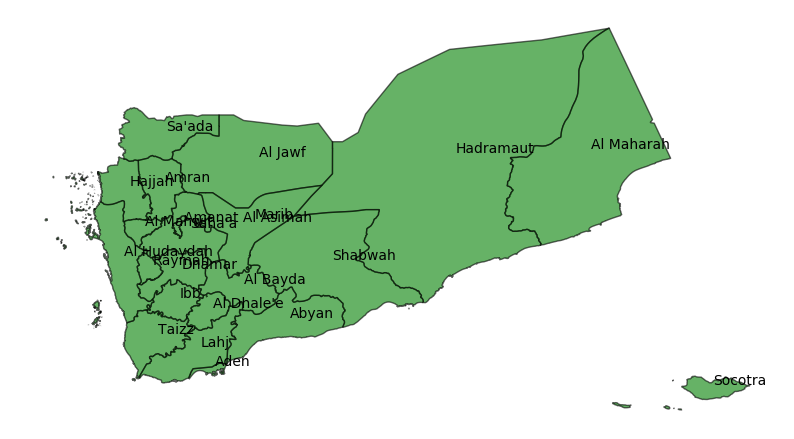

In [15]:
draw_adminstratas("Yemen", AdminStratas["Yemen"], "../Shape Files/shapefiles/Yemen/administrative level 1", figsize = (10, 7), 
                  cmap = "ocean", annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Yemen/map_rcsi_yemen.png", dpi = 300)

- **Nigeria (NGA)**: Nigeria is divided into 36 states. It also includes The Federal Capital Territory that is not a state and it is under the direct control of the federal government. The AdminStrata items of the rCSI dataframe cover 3 states: Adamawa, Borno and Yobe. 

In [16]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

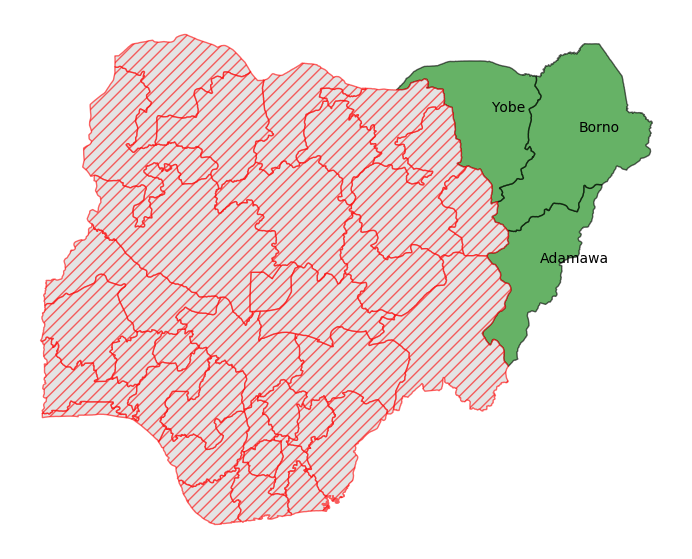

In [17]:
draw_adminstratas("Nigeria", AdminStratas["Nigeria"], "../Shape Files/shapefiles/Nigeria/administrative level 1", figsize = (10, 7), annotation = True, 
                  cmap = "ocean", annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Nigeria/map_rcsi_nigeria.png", dpi = 300)

- **Syria (SYR)**: the governatores of the Syria country are 14. The rCSI dataframe has the values of 13 governorates (Idleb governatore not included).

In [18]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Al-Hasakeh', 'Aleppo', 'As-Sweida', 'Damascus', "Dar'a", 'Hama',
       'Homs', 'Lattakia', 'Rural Damascus', 'Tartous', 'Ar-Raqqa',
       'Deir-ez-Zor', 'Quneitra'], dtype=object)

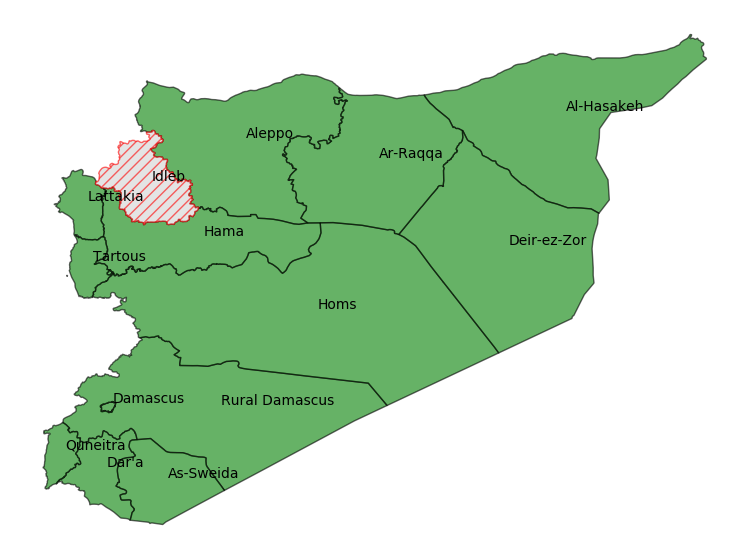

In [19]:
draw_adminstratas("Syria", AdminStratas["Syria"], "../Shape Files/shapefiles/Syria/administrative level 1", figsize = (10, 7), 
                  cmap = "ocean", annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Syria/map_rcsi_syria.png", dpi = 300)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The rCSI dataframe has the values of all 13 regions.

In [20]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

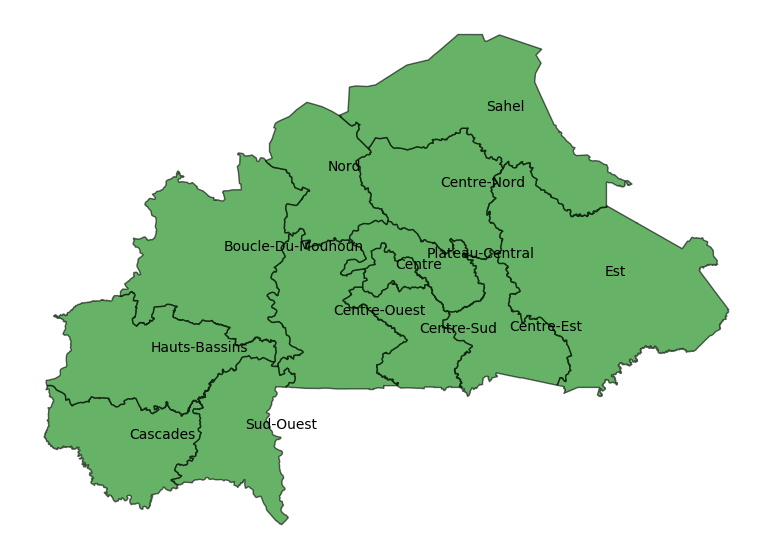

In [21]:
draw_adminstratas("Burkina Faso", AdminStratas["Burkina Faso"], "../Shape Files/shapefiles/Burkina Faso/administrative level 1", figsize = (10, 7), 
                  cmap = "ocean", annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Burkina Faso/map_rcsi_burkina.png", dpi = 300)

## Data analysis

In [22]:
# Check the min e max values of the Metric item.
print("The min and max values of the Metric item:")
print(df.Metric.min(), ",", df.Metric.max())

The min and max values of the Metric item:
0.0 , 99.97458240652935


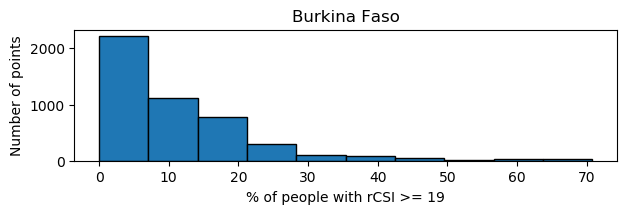

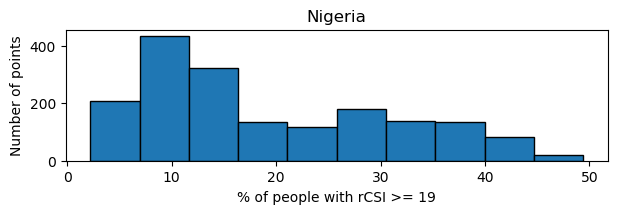

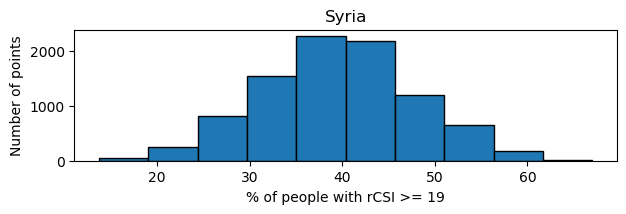

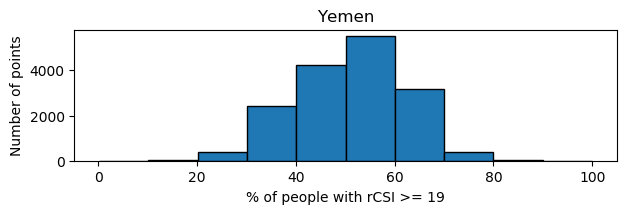

In [23]:
# Create an histogram referred to the values of the metric for each country.
def hist_rcsi(group):
    # Plot hist.
    fig, ax = plt.subplots(figsize = (7, 1.7))
    data = group.Metric.dropna().values
    ax.hist(data, ec = "k")
    ax.set_title(group.name)
    ax.set_ylabel("Number of points")
    ax.set_xlabel("% of people with rCSI >= 19")
    plt.show()

df.groupby("Country").apply(hist_rcsi);

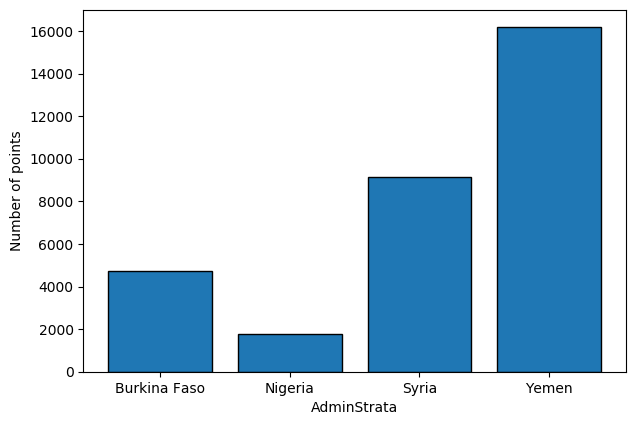

In [24]:
# Create an histogram referred to the number of total points for each country.
n_points = df.groupby("Country")["Metric"].count()

fig, ax = plt.subplots(figsize = (7, 4.7))
ax.bar(n_points.index, n_points.values, ec = "k")
ax.set_ylabel("Number of points")
ax.set_xlabel("AdminStrata")
plt.show()

## Creation of the time-series

We create the time-series based on the Metric value (% of people with rCSI>=19).

In [25]:
# Delete the unused columns.
df.drop(["SvyDate", "SvyDateRange"], axis = 1, inplace = True) 
# Creation of an accurate datetime format.
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) # Sort on datetime.
# If for some adminstrata of the same country there are more values for the same day, we take the mean.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,Metric
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,19.49950
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,19.56738
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,20.40068
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,20.40558
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,19.23853


In [26]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time-series.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"])
df.columns = df.columns.droplevel(0)
df.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["rCSI"]), df.columns)), names = ["Country", "AdminStrata", "Indicator"])
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun Cascades Centre Centre-Est Centre-Nord   
Indicator                rCSI     rCSI   rCSI       rCSI        rCSI   
Datetime                                                               
2018-08-22                NaN      NaN    NaN        NaN         NaN   
2018-08-23                NaN      NaN    NaN        NaN         NaN   
2018-08-24                NaN      NaN    NaN        NaN         NaN   
2018-08-25                NaN      NaN    NaN        NaN         NaN   
2018-08-26                NaN      NaN    NaN        NaN         NaN   

Country                                                      ...      Yemen  \
AdminStrata Centre-Ouest Centre-Sud  Est Hauts-Bassins Nord  ...     Hajjah   
Indicator           rCSI       rCSI rCSI          rCSI rCSI  ...       rCSI   
Datetime                                                     ...              
2018-08-22           NaN        NaN  NaN           NaN  NaN  ...  66.698570   
2018-08-23           NaN        NaN  NaN           NaN  NaN  ...  61.331133   
2018-08-24           NaN        NaN  NaN           NaN  NaN  ...  62.286205   
2018-08-25           NaN        NaN  NaN           NaN  NaN  ...  59.525377   
2018-08-26           NaN        NaN  NaN           NaN  NaN  ...  59.384136   

Country                                                                        \
AdminStrata        Ibb       Lahj      Marib     Raymah     Sa'ada     Sana'a   
Indicator         rCSI       rCSI       rCSI       rCSI       rCSI       rCSI   
Datetime                                                                        
2018-08-22   60.797456  44.782684  60.490004  56.301100  46.435518  52.667849   
2018-08-23   61.011650  44.038726  59.568557  57.324106  45.261947  50.214606   
2018-08-24   62.032249  43.296925  58.277608  57.417614  44.520462  50.073157   
2018-08-25   60.993741  42.149079  56.908462  55.324169  46.345940  48.791655   
2018-08-26   58.800240  42.146629  57.722567  57.666522  43.294599  48.839640   

Country                                       
AdminStrata    Shabwah    Socotra      Taizz  
Indicator         rCSI       rCSI       rCSI  
Datetime                                      
2018-08-22   34.302200  38.303104  50.919038  
2018-08-23   36.742499  39.545071  50.415852  
2018-08-24   35.857748  41.867782  49.391298  
2018-08-25   34.658434  48.585591  50.302392  
2018-08-26   35.913080  48.662394  50.293046  

[5 rows x 51 columns]

In [27]:
# Plot time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

In [28]:
def full_extent(ax, pad = 0.0):
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

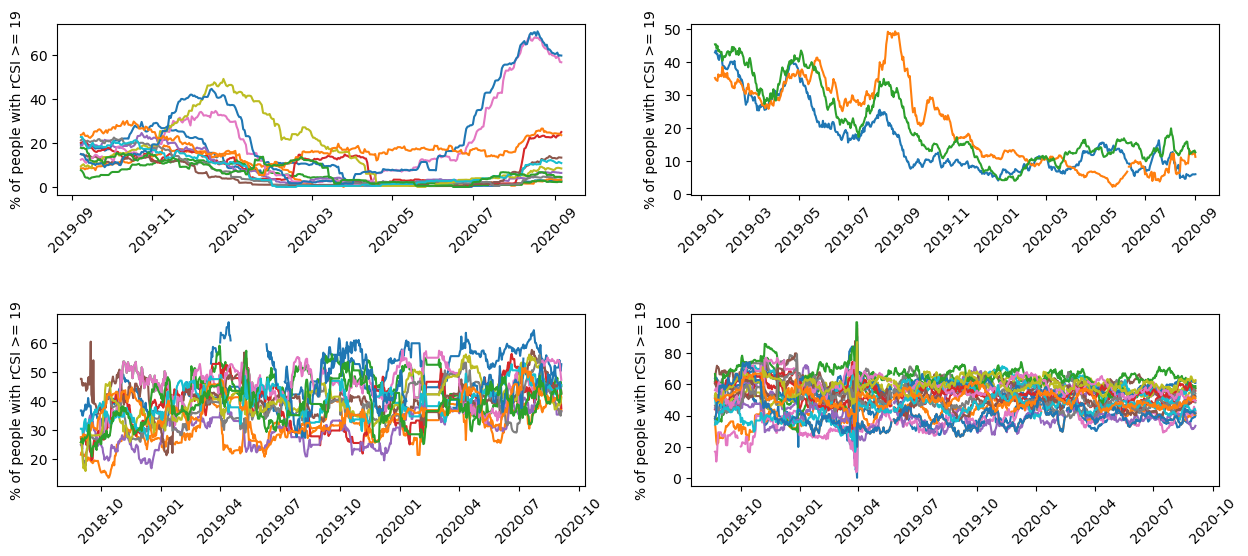

In [29]:
# Plot the original time-series of the rCSI indicator for each country.
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 6))
fig.subplots_adjust(hspace = 0.7)
axs = axs.ravel()
for i, country in enumerate(df.columns.get_level_values(0).unique()):
    axs[i].plot(df[country])
    #axs[i].set_title(country)
    #axs[i].set_xlabel("Datetime")
    axs[i].set_ylabel("% of people with rCSI >= 19")
    axs[i].tick_params(axis = "x", labelrotation = 45)
    # Save just the portion of the current axes.
    extent = full_extent(axs[i]).transformed(fig.dpi_scale_trans.inverted())
    extent = axs[i].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(PATH_TO_SAVE_DATA + "%s/ts_rcsi_%s.png" % (country, country), bbox_inches = extent, dpi = 300)

In [30]:
# Save the figure.
fig.savefig(PATH_TO_SAVE_DATA + "ts.png", dpi = 300)

In [31]:
# Now save the time-series of each country keeping as indeces for each time-series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [32]:
df.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rcsi"));

## Adjustment of the time-series (interpolation nan values)

Let's interpolate the nan values between the first and last valid index of each time-series using a linear interpolation up to a limit of 7 days. Finally, we delete the time-series that still have some nan values inside them.

In [33]:
# Let's interpolate the nan values using a linear interpolation up to a limit of 7 days.
def interpolation(group):   
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.interpolate(method = "linear", limit = 7)
    # Delete time-series that still have some NaN values.
    group.dropna(inplace = True, axis = 1)
    return group

df_interpolate = df.groupby(axis = 1, level = [0, 1], group_keys = False).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun Cascades Centre Centre-Est Centre-Nord   
Indicator                rCSI     rCSI   rCSI       rCSI        rCSI   
Datetime                                                               
2018-08-22                NaN      NaN    NaN        NaN         NaN   
2018-08-23                NaN      NaN    NaN        NaN         NaN   
2018-08-24                NaN      NaN    NaN        NaN         NaN   
2018-08-25                NaN      NaN    NaN        NaN         NaN   
2018-08-26                NaN      NaN    NaN        NaN         NaN   

Country                                                      ...      Yemen  \
AdminStrata Centre-Ouest Centre-Sud  Est Hauts-Bassins Nord  ...     Hajjah   
Indicator           rCSI       rCSI rCSI          rCSI rCSI  ...       rCSI   
Datetime                                                     ...              
2018-08-22           NaN        NaN  NaN           NaN  NaN  ...  66.698570   
2018-08-23           NaN        NaN  NaN           NaN  NaN  ...  61.331133   
2018-08-24           NaN        NaN  NaN           NaN  NaN  ...  62.286205   
2018-08-25           NaN        NaN  NaN           NaN  NaN  ...  59.525377   
2018-08-26           NaN        NaN  NaN           NaN  NaN  ...  59.384136   

Country                                                                        \
AdminStrata        Ibb       Lahj      Marib     Raymah     Sa'ada     Sana'a   
Indicator         rCSI       rCSI       rCSI       rCSI       rCSI       rCSI   
Datetime                                                                        
2018-08-22   60.797456  44.782684  60.490004  56.301100  46.435518  52.667849   
2018-08-23   61.011650  44.038726  59.568557  57.324106  45.261947  50.214606   
2018-08-24   62.032249  43.296925  58.277608  57.417614  44.520462  50.073157   
2018-08-25   60.993741  42.149079  56.908462  55.324169  46.345940  48.791655   
2018-08-26   58.800240  42.146629  57.722567  57.666522  43.294599  48.839640   

Country                                       
AdminStrata    Shabwah    Socotra      Taizz  
Indicator         rCSI       rCSI       rCSI  
Datetime                                      
2018-08-22   34.302200  38.303104  50.919038  
2018-08-23   36.742499  39.545071  50.415852  
2018-08-24   35.857748  41.867782  49.391298  
2018-08-25   34.658434  48.585591  50.302392  
2018-08-26   35.913080  48.662394  50.293046  

[5 rows x 50 columns]

In [34]:
# Check what time-series are dropped.
for column in df.columns:
    if column not in df_interpolate.columns:
        print(column)

('Syria', 'Quneitra', 'rCSI')


In [35]:
# Plot time-series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

## Adjustment of March month for the Yemen country

We remove the values for the month of March 2019 beacuse it seems to have some anomalies. We then replace the values using a simple linear interpolation.

### Remove month

In [36]:
def remove_march_Yemen(group):
    country = group.name[0]
    if country == "Yemen":
        mask = (group.index >= "2019-3-1") & (group.index <= "2019-3-31")
        group.loc[mask] = np.nan    
        return group
    else:
        return group

In [37]:
df_interpolate_no_march = df_interpolate.groupby(level = [0, 1], axis = 1, group_keys = False).apply(remove_march_Yemen)

In [38]:
# Plot time-series.
TsIP(df_interpolate_no_march).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

### Replace month

In [39]:
def interpolate_march_Yemen(group):
    country = group.name[0]
    if country == "Yemen":
        mask = (group.index >= "2019-3-1") & (group.index <= "2019-3-31")
        group.loc[mask] = np.nan    
        first_idx = group.first_valid_index()
        last_idx = group.last_valid_index()
        group = group.loc[first_idx:last_idx]
        group = group.interpolate(method = "linear")
        return group
    else:
        return group

In [40]:
df_interpolate_replace_month = df_interpolate.groupby(level = [0, 1], axis = 1, group_keys = False).apply(interpolate_march_Yemen)

In [41]:
# Plot time-series.
TsIP(df_interpolate_replace_month).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with rCSI >= 19", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

In [42]:
df_interpolate_replace_month.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_rcsi-interpolate"));